## Aim: To detect Wheter a sent email is a spam or not

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import re

In [2]:
en_stopwords = nltk.corpus.stopwords.words('english')

In [3]:
data = pd.read_csv("./spam.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
le = LabelEncoder()
data.Category = le.fit_transform(data.Category)

In [5]:
data

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Data Cleaning and features_engineering

In [11]:
lematizer = WordNetLemmatizer()
def email_cleaning(email):
    ## Remove punctuation character
    ## tokenisation
    tokens = re.split("\W+",email)
    
    cleaned = [lematizer.lemmatize(token) for token in tokens if token not in en_stopwords if token not in string.punctuation]
    
    return " ".join(cleaned)

data['Content_cleaned'] = data['Message'].apply(lambda x:email_cleaning(x.lower()))
data.head()
    

,Category,Message,Content_cleaned
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [12]:
data['Character_count'] = data['Content_cleaned'].apply(lambda x:len(x)-x.count(" "))

### Exploratory Data Analysis

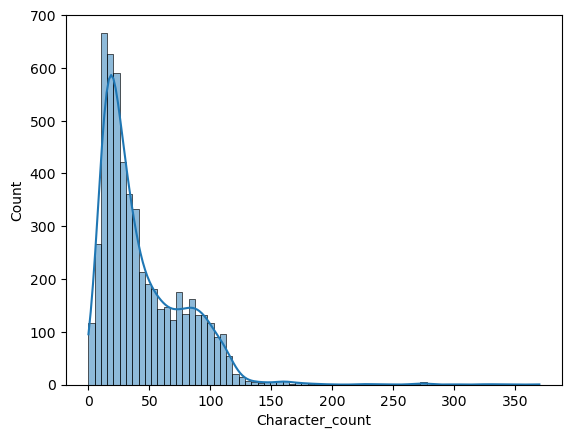

In [35]:
sns.histplot(data,x='Character_count',kde=True);

In [10]:
from scipy.stats import kstest, norm

statistic, p_value = kstest(data.Character_count, 'norm')
p_value

0.0

### comments

the above boxplot shows that the character_count distribution is asymetric, and we have a lot of outliers in the dataset according to the email length

the histogram shows that this distribution is not normal and we verified this hypothesis doing kolmogorov smirnov test and we have a p-value less than 5%

## Vectorization with TF-IDF 

In [13]:
tdif_vectoriszation = TfidfVectorizer()
tfidf_final = tdif_vectoriszation.fit_transform(data['Content_cleaned'])
print(tfidf_final.shape)

(5572, 8050)


In [14]:
X_train,X_test,y_train,y_test = train_test_split(tfidf_final.toarray(),data.Category,test_size=.2)

In [15]:
%%time
from sklearn.metrics import precision_recall_fscore_support as score,confusion_matrix
from sklearn import svm
from sklearn.model_selection import cross_val_score

svm_clf = svm.SVC()
cross_val_scores = cross_val_score(svm_clf, tfidf_final.toarray(), data.Category, cv=5)

CPU times: total: 15min 42s
Wall time: 9min 16s


In [16]:
print("Scores de validation croisée:", cross_val_scores)

Scores de validation croisée: [0.97488789 0.97309417 0.96858169 0.96768402 0.97396768]


In [17]:
mean_score = cross_val_scores.mean()
print(f"Moyenne des scores de validation croisée: {mean_score*100:.2f} %")

Moyenne des scores de validation croisée: 97.16 %


In [18]:
%%time
svm_clf.fit(X_train,y_train)

CPU times: total: 2min 4s
Wall time: 1min 13s


SVC()

In [19]:
y_preds = svm_clf.predict(X_test)

In [22]:
cm = confusion_matrix(y_preds,y_test)
cm

array([[960,  31],
       [  1, 123]], dtype=int64)

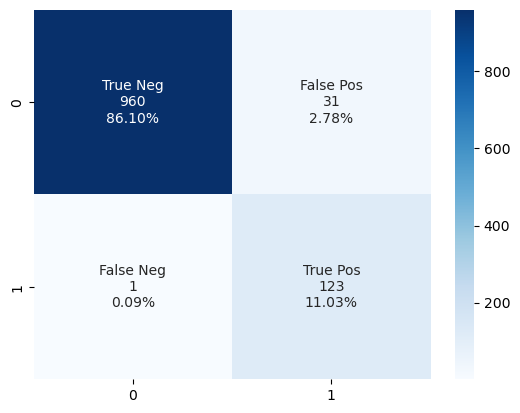

In [23]:
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='');